# Batch images processing

## Inputs

In [2]:
# Import libraries
from calibrations import  build_calibration, calibrate_color_and_distortion, calibrate_color
import os
import shutil
import pandas as pd
from aux_functions import slicing, obtain_pixel_metric, divide_in_sets, ungroup_pic, prepare_pose_dataset
from model_class import model_segmentation
from pictures_class import pictures
from morphometrics_functions import install_morphometrics_packages_r, exploratory_morphometrics_r, run_efourier_pca_morphometrics_r, run_plot_pca_morphometrics_r, run_kmeans_efourier_r, run_obtain_kmeans_classification_r


In [3]:
#Inputs
working_directory="C:/Users/Pheno/Documents/database_almondcv2/"
raw_folder="C:/Users/Pheno/Documents/database_almondcv2/2023/all_sessions_2023/errores"
chessboards="C:/Users/Pheno/Documents/database_almondcv2/calibracion/chessboards"
mtx_input_path=os.path.join(chessboards,"calibration_mtx.npz") ## for distorsion
standard_matrix_color="C:/Users/Pheno/Documents/database_almondcv2/2023/all_sessions_2023/RGB_SEED_0509_2024-09-05-12-29-37_2.jpg" ### a picture to select if some pictures produces errors in color 
info_data_2022="C:/Users/Pheno/Documents/database_almondcv2/info_data.txt"
info_data_2023="C:/Users/Pheno/Documents/database_almondcv2/info_data_2023.txt"

zip_file_coin=os.path.join(working_directory,"coin_640_slices_2023set.zip")
zip_file_group=os.path.join(working_directory,"rectangles_set_2023_shell.zip")
zip_file_shell=os.path.join(working_directory,"shell_2022_320.zip")
zip_file_seed=os.path.join(working_directory,"seed_2022_21102024.zip")


models_directory="C:/Users/Pheno/Documents/database_almondcv2/models/"
pre_model=os.path.join(models_directory, "yolo11s-seg.pt")

coin_model_path=os.path.join(models_directory,"coin_2023_yolov11s_640.pt")

group_model_path_1=os.path.join(models_directory, "rectangles_shell_2023_imgsize_1280.pt")
group_model_path_2=os.path.join(models_directory, "rectangles_seed_2023_imgsz_1600.pt")
group_model_path_2022="rectangle_2022_yolov11s_1280.pt"

shell_model_path=os.path.join(models_directory, "shell_2022_yolov11s_320.pt")
seed_model_path=os.path.join(models_directory, "seed_2022_yolov11s_320.pt")
#outputs
output="C:/Users/Pheno/Documents/database_almondcv2"
output_calibrated=os.path.join(output,"calibrated_pics_2022/")
os.makedirs(output_calibrated, exist_ok=True)

## Color and distorsion correction

In [ ]:
# If you need to create distortion model
build_calibration(chessboardSize=(6, 8), frameSize=(5472,3648), dir_path=chessboards, 
                  image_format=".jpg", size_of_chessboard_squares_mm=20)

In [ ]:
#Ahora mismo esta puesto en modo calibracion los errores utilizando una foto como referencia, para calibracion normal quitar la standard_matrix_color
calibrate_color_and_distortion(raw_folder=raw_folder,mtx_input_path=mtx_input_path,output_calibrated=output_calibrated,
                                radius_param=10, standard_matrix=standard_matrix_color)

In [ ]:
#Si solo quieres hacer color esta la función

# calibrate_color(input_folder=raw_folder, output_path=output_calibrated,standard_matrix=standard_matrix_color)
calibrate_color(input_folder=raw_folder, output_path=output_calibrated,standard_matrix=standard_matrix_color,
                 force_standard_matrix="Yes")

In [ ]:
#CHUNK para mover automaticamente lo que este en la lista errores a donde tu queiras
#first we move 

carpeta_destino = os.path.join(raw_folder,"errores")    # Cambia esto por la ruta correcta

# Crea la carpeta de destino si no existe
os.makedirs(carpeta_destino, exist_ok=True)


# Lee el archivo de texto con los nombres de las imágenes
with open(os.path.join(output_calibrated,"errors_in_calibrations.txt"), "r") as archivo:
    for nombre_imagen in archivo:
        nombre_imagen = nombre_imagen.strip()  # Elimina espacios en blanco y saltos de línea
        ruta_imagen_origen = os.path.join(raw_folder, nombre_imagen)
        
        # Verifica si el archivo existe antes de moverlo
        if os.path.exists(ruta_imagen_origen):
            # Mueve la imagen a la carpeta de destino
            shutil.copy(ruta_imagen_origen, carpeta_destino)
            print(f"Moviendo: {nombre_imagen} a {carpeta_destino}")
        else:
            print(f"No se encontró la imagen: {nombre_imagen}")

## Load info data

In [ ]:
#Cargar info_data, se puede cargar ya una columna pixelmetric con la informacion pixel-mm o obtener la metrica pixel desde las imagenes.
info_data_df=pd.read_csv(info_data_2022,sep="\t")
# Si las hemos calibrado añadimos CL delante
info_data_df['Name_picture'] = info_data_df['Name_picture'].apply(lambda x: 'CL_' + x)
info_data_df

### Obtain pixel_metric from the pictures

In [ ]:
# Si no tienes un modelo para reconocer tu objeto de referencia debes crearlo
#Se comienza haciendo particiones de la imagen con la función slicing para introducirlas en CVAT

slicing(input_folder=output_calibrated,output_directory=working_directory,
        name_slicing="gsgsg", number_pictures=60,
          crop="left", slice_height=640, slice_width=640, overlap_height_ratio=0.2, overlap_width_ratio=0.2, crop_level=2)


In [ ]:
# Posteriormente se tiene que segmentar en CVAT, y ese output se leera para entrenar el modelo y ver si funciona bien, para ello utilizamos la función
# train model, pon el archivo.zip en el working directory.

coin_model=model_segmentation(working_directory=working_directory)
coin_model.train_segmentation_model(input_zip=zip_file_coin, epochs=80,imgsz=640,
                                     name_segmentation="coin_640px_slices640_26102024_set2023_retina", pre_model=pre_model
                                     , batch=16)

In [ ]:
# Si tenemos el modelo ya simplemente podemos cargarlo y aplicarlo sobre la carpeta que queramos

coin_model_saved=model_segmentation(working_directory=working_directory)
contours_coin=coin_model_saved.slice_predict_reconstruct(input_folder=output_calibrated, imgsz=640,
                                                         model_path=coin_model_path, slice_height=640, slice_width=640,
                                                         overlap_height_ratio=0.2, overlap_width_ratio=0.2,
                                                           retina_mask=True)




In [ ]:
info_data_completed=obtain_pixel_metric(info_data=info_data_df, contours=contours_coin,
                                         output_directory=working_directory, reference=24.25)

In [ ]:
info_data_completed

### Desagrupar imagenes

In [ ]:
# Una vez hemos completado ya el pixelmetric, si tenemos fotos agrupadas, debemos desagruparlas y conectarlas con su ID
#Para posteriormente sacar las medidas que queramos. Esta vez no hacemos slicing, peusto que los grupos son mas grandes que las slcies.
# divide_in_sets(input_folder=output_calibrated,output_directory=working_directory, division_name="rectangle_group_2023", number_pictures=100)

#Esta vez hacemos solo shell
folder_shell=os.path.join(working_directory, "Seed_2023_set")
divide_in_sets(input_folder=folder_shell,output_directory=working_directory, division_name="rectangle_group_2023_seed", number_pictures=60)

In [ ]:
#Ahora vamos a entrenar un modelo para que reconozca los grupos

group_model=model_segmentation(working_directory=working_directory)
group_model.train_segmentation_model(input_zip=zip_file_group, epochs=80,imgsz=1280,
                                      name_segmentation="rectangle_group_2023set_shell", pre_model=pre_model, batch=6)

In [ ]:
#ESTO DESPUES PARA LOS CONTORNOS EN GROUPED PICTURES

# Si tenemos el modelo ya simplemente podemos cargarlo y aplicarlo sobre la carpeta que queramos
#Esta funcion se puede optimizar, cuando hay muchas fotos se llena la RAM y va mas lento a partir de las 300 fotos.Habría que hacer tandas, lo que lo peta es la retina mask. 
group_model_saved=model_segmentation(working_directory=working_directory)
contours_groups=group_model_saved.predict_model(model_path=group_model_path_2,
                               folder_input=os.path.join(working_directory, "Seed_2023_set"),
                               imgsz=1600, check_result=False, max_det=2, retina_mask=False)

In [ ]:
#Ahora que ya tenemos los contornos, podemos aplicarlo a nuestras imagenes, y tambien coordinaar el info_data_df
info_data_completed_path=os.path.join(working_directory, "info_data_completed_2023.txt")
info_data_completed=pd.read_csv(info_data_completed_path,sep="\t")
#PARA QUE FUNCIONE EN 2023 EDITAR EL INFO DATA EN donde pone Sample number cambiar los 0 por 1.
info_data_completed.loc[info_data_completed['Sample_number'] == 0, 'Sample_number'] = 1


ungroup_pic(input_contours=contours_groups, output_path=working_directory, info_file=info_data_completed, axis="Y")

## Measuring

### Shell Almonds

In [ ]:
#Vamos a entrenar un modelo para las almendras con cascara
#Vamos a separar en una carpeta las imagenes de almendras con cascara
info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]

# Directorio donde están las imágenes
directorio_imagenes = f"{working_directory}/Ungrouped_pics"  # Cambia esto por la ruta correcta
# Directorio de destino donde copiarás las imágenes
directorio_destino = f"{working_directory}/Shell_ungrouped_pics"

# Crear el directorio de destino si no existe
os.makedirs(directorio_destino, exist_ok=True)

# Copiar las imágenes
for index, row in info_data_df.iterrows():
    imagen_relativa = row['Sample_picture']  # Obtener la ruta relativa de la imagen
    imagen_path = os.path.join(directorio_imagenes, imagen_relativa)  # Ruta completa

    try:
        # Copiar la imagen al directorio de destino
        shutil.copy(imagen_path, os.path.join(directorio_destino, os.path.basename(imagen_path)))
        print(f"Imagen copiada: {imagen_path} a {directorio_destino}")
    except Exception as e:
        print(f"No se pudo copiar la imagen {imagen_path}. Error: {e}")

In [ ]:
#Bien ahora vamos a hacer el slicing y a segmentar y etiquetar las imagenes

directorio_imagenes=os.path.join(working_directory, "Ungrouped_pics_shell_2023")


slicing(input_folder=directorio_imagenes,output_directory=working_directory,name_slicing="Slices_for_shell_2023_29102024_320", number_pictures=50, slice_height=320, slice_width=320)

In [ ]:
#Ahora vamos a entrenar el modelo 

shell_model=model_segmentation(working_directory=working_directory)
shell_model.train_segmentation_model(input_zip=zip_file_shell, epochs=100,imgsz=640, name_segmentation="shell_2022_yolov11",
                                      pre_model=pre_model, batch=16)


In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con watershed

info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_shell2023.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "fotos_prueba_2023")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.slice_predict_reconstruct(input_folder=input_folder,imgsz=320, model_path=shell_model_path,
                                          slice_height=320, slice_width=320,overlap_height_ratio=0.2,
                                          overlap_width_ratio=0.2)
shell_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Shell_almond", binary_masks=False, project_name="Shell_2023_prueba_30102024")
shell_object.set_postsegmentation_parameters(sahi=False, segmentation_input=shell_masks, smoothing=True, smoothing_iterations=2, kernel_smoothing=3,
                        watershed=True, kernel_watershed=5, threshold_watershed=0.6)
shell_object.measure_almonds(margin=100)

In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con sahi

info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "fotos_prueba")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.predict_model_sahi(model_path=shell_model_path, check_result=False, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.2, overlap_height_ratio=0.4,
                                                overlap_width_ratio=0.4, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.9,
                                                  imgsz=320)
shell_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Shell_almond", binary_masks=True, project_name="Shell_2022_congreso_frutadehueso")
shell_object.set_postsegmentation_parameters(sahi=True, segmentation_input=shell_masks)
shell_object.measure_almonds(margin=400)

### Seed Almonds

In [ ]:
#Vamos a entrenar un modelo para las almendras sin cascara
#Vamos a separar en una carpeta las imagenes de almendras sin cascara
info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "No"]

# Directorio donde están las imágenes
directorio_imagenes = f"{working_directory}/Ungrouped_pics"  # Cambia esto por la ruta correcta
# Directorio de destino donde copiarás las imágenes
directorio_destino = f"{working_directory}/Seed_ungrouped_pics"

# Crear el directorio de destino si no existe
os.makedirs(directorio_destino, exist_ok=True)

# Copiar las imágenes
for index, row in info_data_df.iterrows():
    imagen_relativa = row['Sample_picture']  # Obtener la ruta relativa de la imagen
    imagen_path = os.path.join(directorio_imagenes, imagen_relativa)  # Ruta completa

    try:
        # Copiar la imagen al directorio de destino
        shutil.copy(imagen_path, os.path.join(directorio_destino, os.path.basename(imagen_path)))
        print(f"Imagen copiada: {imagen_path} a {directorio_destino}")
    except Exception as e:
        print(f"No se pudo copiar la imagen {imagen_path}. Error: {e}")

In [ ]:
slicing(input_folder=directorio_destino,output_directory=working_directory,name_slicing="Slices_for_seed_21102024_320", number_pictures=30, slice_height=320, slice_width=320)

In [ ]:
seed_model=model_segmentation(working_directory=working_directory)
seed_model.train_segmentation_model(input_zip=zip_file_seed, epochs=100,imgsz=640, name_segmentation="seed_2022_211024",
                                      pre_model=pre_model, batch=16)

In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas

info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "No"]
input_folder=os.path.join(working_directory, "fotos_prueba")
seed_masks=model_segmentation(working_directory=working_directory)
seed_masks=shell_masks.slice_predict_reconstruct(input_folder=input_folder,imgsz=640, model_path=shell_model_path,
                                          slice_height=320, slice_width=320,overlap_height_ratio=0.2,
                                          overlap_width_ratio=0.2)
seed_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Seed_almond", binary_masks=True, project_name="Seed_2022_21102022",
                        segmentation_maks=shell_masks, smoothing=True, smoothing_iterations=2, kernel_smoothing=5,
                        watershed=True, kernel_watershed=5, threshold_watershed=0.5)
seed_object.measure_almonds()

In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas
#Con sahi

info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "No"]
input_folder=os.path.join(working_directory, "fotos_prueba_seed_2022")
seed_masks=model_segmentation(working_directory=working_directory)
seed_masks=seed_masks.predict_model_sahi(model_path=seed_model_path, check_result=False, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.2, overlap_height_ratio=0.3,
                                                overlap_width_ratio=0.3, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.95,
                                                  imgsz=320)
seed_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Seed_almond", binary_masks=False, project_name="seed_2022_congreso_frutadehueso")
seed_object.set_postsegmentation_parameters(sahi=True, segmentation_input=seed_masks)
seed_object.measure_almonds()

## Morphometrics

In [ ]:
input_masks="C:/Users/Pheno/Documents/database_almondcv2/Momocs/input"
info_data_masks="C:/Users/Pheno/Documents/database_almondcv2/Momocs/input/binary_masks_info_table.txt"

### Momocs

In [ ]:
# Primero hay que ejecutar un script para instalar las librerías necesarias
install_morphometrics_packages_r()

In [ ]:
#Analisis exploratorio para decidir nharmonics
exploratory_morphometrics_r(info_data=info_data_masks, grouping_factor="ID", directorio_input=input_masks,
                             output_directory=working_directory, show=True, nharmonics=10,nexamples=2)

In [ ]:
ruta=os.path.join(working_directory,"exploratory_plots","outlines_objects.rds")
run_efourier_pca_morphometrics_r(ruta_outline_objects=ruta, nharmonics=10, output_directory=working_directory, show=True)

In [ ]:
ruta=os.path.join(working_directory,"efourier_results","pca_fourier.rds")
run_plot_pca_morphometrics_r(ruta_pca_objects=ruta, output_directory=working_directory, grouping_factor="ID", chull_layer="TRUE", chullfilled_layer="TRUE")

Salida del comando R:
Imagen de los centroides con 1 clusters guardada como centroides_k1_cluster_1.jpg 
Imagen de los centroides con 2 clusters guardada como centroides_k2_cluster_1.jpg 
Imagen de los centroides con 2 clusters guardada como centroides_k2_cluster_2.jpg 
Imagen de los centroides con 3 clusters guardada como centroides_k3_cluster_1.jpg 
Imagen de los centroides con 3 clusters guardada como centroides_k3_cluster_2.jpg 
Imagen de los centroides con 3 clusters guardada como centroides_k3_cluster_3.jpg 
Imagen de los centroides con 4 clusters guardada como centroides_k4_cluster_1.jpg 
Imagen de los centroides con 4 clusters guardada como centroides_k4_cluster_2.jpg 
Imagen de los centroides con 4 clusters guardada como centroides_k4_cluster_3.jpg 
Imagen de los centroides con 4 clusters guardada como centroides_k4_cluster_4.jpg 
Imagen de los centroides con 5 clusters guardada como centroides_k5_cluster_1.jpg 
Imagen de los centroides con 5 clusters guardada como centroides_

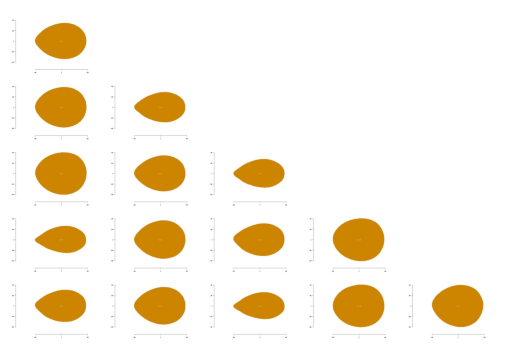

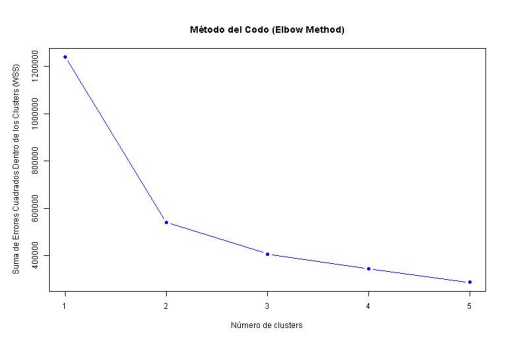

In [7]:
ruta=os.path.join(working_directory,"efourier_results","pca_fourier.rds")
run_kmeans_efourier_r(ruta_pca_objects=ruta, output_directory=working_directory,max_clusters=5)

Salida del comando R:
[1] "hello"
  [1] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_1" 
  [2] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_10"
  [3] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_11"
  [4] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_12"
  [5] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_13"
  [6] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_14"
  [7] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_15"
  [8] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_16"
  [9] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_17"
 [10] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_18"
 [11] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_19"
 [12] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_2" 
 [13] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_20"
 [14] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1.png_21"
 [15] "CL_RGB_SEED_shell_12_08_1_2024-08-12-13-09-15_2_1

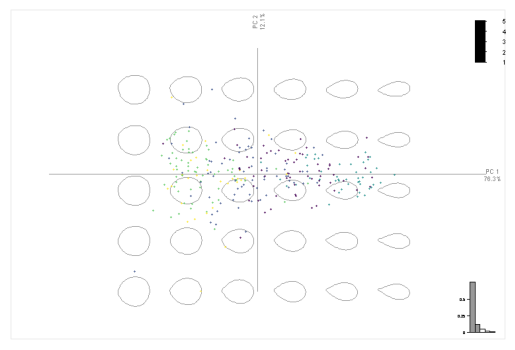

In [11]:
ruta_1=os.path.join(working_directory,"efourier_results","pca_fourier.rds")
ruta_2=os.path.join(working_directory,"kmeans_results","kmeans_pca_fourier_5.rds")
run_obtain_kmeans_classification_r(ruta_pca_objects=ruta_1, output_directory=working_directory, ruta_kmeans_objects=ruta_2,
                                   chull_layer="TRUE", chullfilled_layer="TRUE")

## SUCIO

In [ ]:
#ROTAR 

from PIL import Image
import os

# Ruta de la carpeta con las imágenes
folder_path = output_calibrated

# Recorrer cada archivo en la carpeta
for filename in os.listdir(folder_path):
    if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Filtrar solo archivos de imagen
        # Ruta completa del archivo
        img_path = os.path.join(folder_path, filename)
        
        # Abrir la imagen
        with Image.open(img_path) as img:
            # Rotar la imagen 90 grados en sentido contrario a las agujas del reloj
            rotated_img = img.rotate(90, expand=True)
            
            # Sobrescribir la imagen rotada en la misma ubicación
            rotated_img.save(img_path)

print("Rotación y guardado completados.")

In [ ]:
#Quiero separar en dos carpetas shell y no shell

import pandas as pd
import shutil
import os

# Cargar el DataFrame (asegúrate de cambiar 'ruta_al_archivo' por la ruta de tu archivo)
df = pd.read_csv(info_data,sep="\t")

# Definir las carpetas de origen y destino
carpeta_origen = output_calibrated
carpeta_destino_yes = os.path.join(working_directory, "Shell_2023_set")
carpeta_destino_no = os.path.join(working_directory, "Seed_2023_set")

# Crear las carpetas de destino si no existen
os.makedirs(carpeta_destino_yes, exist_ok=True)
os.makedirs(carpeta_destino_no, exist_ok=True)

# Iterar sobre las filas del DataFrame
for index, row in df.iterrows():
    nombre_imagen = row['Name_picture']  # Cambia 'NombreImagen' al nombre de la columna en tu DataFrame
    shell_value = row['Shell']           # Cambia 'Shell' al nombre exacto de la columna en tu DataFrame
    nombre_imagen = f"CL_{nombre_imagen}"
    # Definir la ruta completa de la imagen en la carpeta de origen
    ruta_origen = os.path.join(carpeta_origen, nombre_imagen)
    
    # Comprobar si el valor de Shell es 'Yes' o 'No' y definir la carpeta de destino
    if shell_value == 'Yes':
        ruta_destino = os.path.join(carpeta_destino_yes, nombre_imagen)
    elif shell_value == 'No':
        ruta_destino = os.path.join(carpeta_destino_no, nombre_imagen)
    else:
        continue  # Saltar filas con otros valores en 'Shell'
    
    # Copiar la imagen a la carpeta de destino correspondiente
    try:
        shutil.copy(ruta_origen, ruta_destino)
        print(f"Imagen '{nombre_imagen}' copiada a {ruta_destino}")
    except FileNotFoundError:
        print(f"Imagen '{nombre_imagen}' no encontrada en {ruta_origen}")

print("Copia de imágenes completada.")


In [ ]:
#Ahora podemos utilizar ya el modelo y la clase picture para obtener todas las medidas

info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "fotos_prueba")
shell_model_path=os.path.join(models_directory, "prueba_Retina_mask_640_shell.pt")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.slice_predict_reconstruct(input_folder=input_folder,imgsz=640, model_path=shell_model_path,
                                          slice_height=640, slice_width=640,overlap_height_ratio=0.2,
                                          overlap_width_ratio=0.2, retina_mask=True)
shell_object=pictures(working_directory=working_directory, input_folder=input_folder,info_file=info_data_df,
                      fruit="Shell_almond", binary_masks=True, project_name="pruebas_retina_mask",
                        segmentation_maks=shell_masks, smoothing=False, smoothing_iterations=2, kernel_smoothing=5,
                        watershed=False, kernel_watershed=5, threshold_watershed=0.5)
shell_object.measure_almonds()

In [ ]:
info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "fotos_prueba")
shell_model_path=os.path.join(models_directory, "prueba_Retina_mask_320_shell.pt")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.predict_model_sahi(model_path=shell_model_path, check_result=True, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.2, overlap_height_ratio=0.3,
                                                overlap_width_ratio=0.3, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.9,
                                                  imgsz=320)


In [ ]:
info_data_df=pd.read_csv(f"{working_directory}/info_data_completed_ungrouped_2022.txt", sep="\t")
info_data_df = info_data_df[info_data_df["Shell"] == "Yes"]
input_folder=os.path.join(working_directory, "fotos_prueba")
shell_model_path=os.path.join(models_directory, "prueba_Retina_mask_320_shell.pt")
shell_masks=model_segmentation(working_directory=working_directory)
shell_masks=shell_masks.predict_model_sahi(model_path=shell_model_path, check_result=True, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.3, overlap_height_ratio=0.2,
                                                overlap_width_ratio=0.2, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.9,
                                                  imgsz=320)


In [ ]:
shell_masks

In [ ]:
unique_ids_df = info_data_completed[~info_data_completed['ID'].str.lower().duplicated(keep=False)]
unique_ids_df

In [ ]:
filtered_df = info_data_completed[info_data_completed['Shell'] == "No"]
filtered_df

In [ ]:
#SEED MODEL 2023
zip_file=os.path.join(working_directory,"seed_320_2023_29102024.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=320,
                                name_segmentation="seed_2023_320_yolov11",
                                      pre_model=pre_model, batch=16, retina_masks=True)
del model

In [ ]:
#Shell MODEL 2023
zip_file=os.path.join(working_directory,"shell_2023_320.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=320,
                                name_segmentation="shell_2023_320_yolov11",
                                      pre_model=pre_model, batch=16, retina_masks=True)
del model

In [ ]:
#Seed MODEL 2022
zip_file=os.path.join(working_directory,"seed_2022_21102024.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=320,
                                name_segmentation="seed_2022_320_yolov11",
                                      pre_model=pre_model, batch=16, retina_masks=True)
del model

In [ ]:
#Shell MODEL 2022
zip_file=os.path.join(working_directory,"shell_2022_320.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=320,
                                name_segmentation="shell_2022_320_yolov11",
                                      pre_model=pre_model, batch=16, retina_masks=True)
del model

In [ ]:
# coin model 2022
zip_file=os.path.join(working_directory,"coin_640_21102024.zip")
model=model_segmentation(working_directory=working_directory)
model.train_segmentation_model(input_zip=zip_file, epochs=100,imgsz=640,
                                name_segmentation="coin_2022_640_yolov11",
                                      pre_model=pre_model, batch=8, retina_masks=True)
del model


In [ ]:

#Prepare dataset for pose estimation
pose_preparation=model_segmentation(working_directory=working_directory)
input_folder=os.path.join(working_directory, "fotos_prueba_2023")
pose_preparation=pose_preparation.predict_model_sahi(model_path=shell_model_path, check_result=False, folder_input=input_folder,
                                            retina_masks=True,
                                              postprocess_match_threshold=0.2, overlap_height_ratio=0.3,
                                                overlap_width_ratio=0.3, postprocess_match_metric="IOS", 
                                                postprocess_type="GREEDYNMM", slice_height=320, slice_width=320,
                                                  confidence_treshold=0.95,
                                                 imgsz=320)

prepare_pose_dataset(segmentation_input=pose_preparation, output_directory=working_directory, output_name="prueba")


In [ ]:

pose_model=model_segmentation(working_directory=working_directory)
zip_file_pose=os.path.join(working_directory, "shell_2023_tip_pose_07112024.zip")
pre_model=os.path.join(models_directory,"yolo11s-pose.pt")
pose_model.train_segmentation_model(input_zip=zip_file_pose, epochs=100,imgsz=256, name_segmentation="shell_2023_yolov11s_pose_2",
                                     pre_model=pre_model, batch=16, pose=True)


In [ ]:
import subprocess
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define la ruta donde quieres guardar la imagen
ruta_imagen = 'C:/Users/Pheno/Documents/database_almondcv2/grafica.png'

# Comando R para generar el gráfico y guardarlo en un archivo PNG
command = f"""
Rscript -e "
# Crear un vector de datos
x <- c(1, 2, 3, 4, 5)
y <- c(1, 4, 9, 16, 25)

# Iniciar el dispositivo gráfico PNG y guardar la imagen en la ruta indicada
png('{ruta_imagen}')

# Crear el gráfico
plot(x, y, main='Gráfico de ejemplo', xlab='X', ylab='Y')

# Cerrar el dispositivo gráfico
dev.off()
"
"""

# Ejecutar el comando R usando subprocess
result = subprocess.run(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Verificar si hubo algún error
if result.stderr:
    print("Error:", result.stderr.decode())
else:
    print("El script R se ejecutó correctamente.")

    # Leer y mostrar la imagen generada por R en Python
    img = mpimg.imread(ruta_imagen)
    imgplot = plt.imshow(img)
    plt.axis('off')  # Desactivar los ejes si es necesario
    plt.show()



In [ ]:
import subprocess

# Ruta al archivo de script de R
ruta_script_r = r'C:\Users\Pheno\prueba.R'

# Definir el comando para ejecutar el script de R
command = f'Rscript "{ruta_script_r}"'

# Ejecutar el comando con subprocess
try:
    result = subprocess.run(command, shell=True, capture_output=True, text=True, check=True)
    
    # Mostrar la salida del comando R
    print("Salida del comando R:")
    print(result.stdout)

    # Mostrar cualquier error si ocurre
    if result.stderr:
        print("Error:")
        print(result.stderr)

except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar el script R: {e.stderr}")


In [ ]:
import subprocess

# Ruta al script de R
ruta_script_r = "C:/Users/Pheno/prueba.R"

# Ejecutar el script de R utilizando subprocess
try:
    # Si tienes Rscript, puedes usarlo directamente
    result = subprocess.run(['Rscript', ruta_script_r], check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print(f"Output del script de R:\n{result.stdout.decode()}")
except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar el script de R:\n{e.stderr.decode()}")

In [ ]:
import subprocess
import os
from PIL import Image
import matplotlib.pyplot as plt
import time

# Ruta al archivo de script de R
ruta_script_r = r'C:\Users\Pheno\prueba.R'

# Definir el comando para ejecutar el script de R
command = f'Rscript "{ruta_script_r}"'

# Ruta de salida del archivo gráfico generado
ruta_imagen = r'C:\Users\Pheno\HOLA.png'

# Ejecutar el comando con subprocess
try:
    # Ejecutar el script R
    result = subprocess.run(command, shell=True, capture_output=True, text=True, check=True)
    
    # Mostrar la salida del comando R
    print("Salida del comando R:")
    print(result.stdout)

    # Mostrar cualquier error si ocurre
    if result.stderr:
        print("Error:")
        print(result.stderr)

    # Esperar un poco para asegurarse de que la imagen se haya guardado
    time.sleep(2)  # Esperar 2 segundos (ajustable si es necesario)

    # Verificar si la imagen fue generada
    if os.path.exists(ruta_imagen):
        print(f"La imagen fue generada correctamente en {ruta_imagen}")
        
        # Abrir y mostrar la imagen en Python usando PIL y matplotlib
        img = Image.open(ruta_imagen)
        plt.imshow(img)
        plt.axis('off')  # Desactivar los ejes
        plt.show()
    else:
        print("No se pudo encontrar la imagen generada.")

except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar el script R: {e.stderr}")


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Ruta de la imagen que deseas mostrar
ruta_imagen = r'C:\Users\Pheno\HOLA.png'  # Sustituye por tu ruta

# Abrir la imagen con PIL
img = Image.open(ruta_imagen)

# Mostrar la imagen con matplotlib
plt.imshow(img)
plt.axis('off')  # Desactivar los ejes
plt.show()

In [ ]:
import subprocess

# Definir el comando de R para imprimir el directorio de trabajo
command = """
Rscript -e
"""
script="""# Intentar imprimir el directorio de trabajo
# cat('Directorio de trabajo de R: ', getwd(), '\\n')"""

# Ejecutar el comando con subprocess
try:
    result = subprocess.run(command, shell=True, capture_output=True, text=True, check=True)
    
    # Mostrar la salida del comando
    print("Salida del comando R:")
    print(result.stdout)  # Mostrar la salida de R (el directorio de trabajo de R)

    # Mostrar cualquier error si ocurre
    if result.stderr:
        print("Error:")
        print(result.stderr)

except subprocess.CalledProcessError as e:
    print(f"Error al ejecutar el comando R: {e.stderr}")

